# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier



---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# Fill this in based on where you saved the training and testing data

training_file = '../data/Signs/train.p'
validation_file='../data/Signs/valid.p'
testing_file = '../data/Signs/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration



###  Basic Summary of the Data Set 

In [2]:
import numpy as np

# Number of training examples
n_train = len(X_train)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = np.shape(X_train[0])

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Visualization of the dataset

In [3]:
#count number of each class examples
#and store the index of the last one
classIndicies = [np.where(y_train == i)[0] for i in range(n_classes)]
classCounts = [np.size(array) for array in classIndicies]




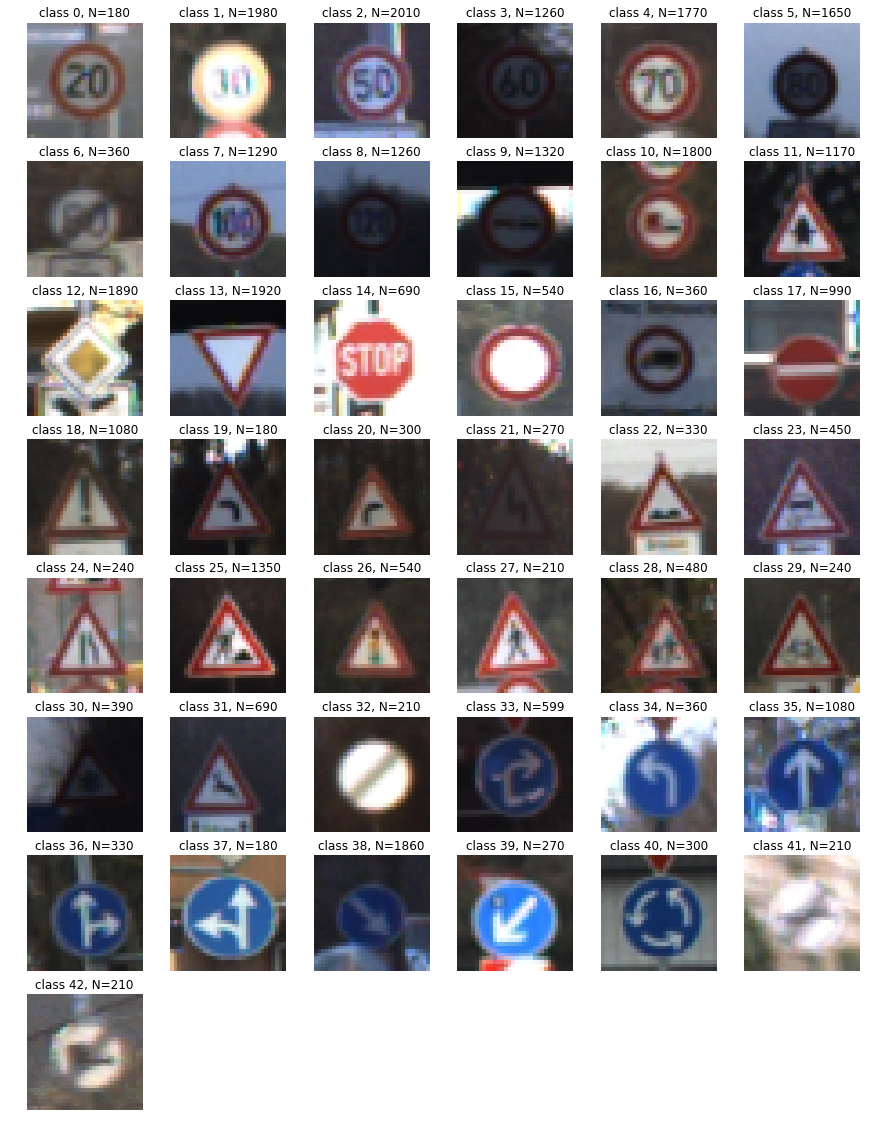

In [4]:
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
get_ipython().magic('matplotlib inline')
import matplotlib.gridspec as gridspec

#display example of each class and show number of samples
cols = 6
figsize = (15, 20)

gs = gridspec.GridSpec(n_classes // cols + 1, cols)

fig1 = plt.figure(num=1, figsize=figsize)
ax = []

exShape = list(X_train.shape);
exShape[0] = n_classes;
examples = np.empty(exShape, dtype=np.uint8)
for i in range(n_classes):
    row = (i // cols)
    col = i % cols
    ax.append(fig1.add_subplot(gs[row, col]))
    ax[-1].set_title('class %d, N=%d' % (i ,  classCounts[i]))
    #example
    img = X_train[classIndicies[i][40]]
    #rescale to make dark images visible
    cf = np.int(255/np.max(img)) 
    examples[i] = img*cf;
    ax[-1].imshow(img*cf)
    ax[-1].axis('off')
    

----

## Step 2: Design and Test a Model Architecture



### Pre-process the Data Set (normalization, grayscale, etc.)

In [5]:
### Preprocess the data here. Preprocessing steps could include normalization, converting to grayscale, etc.
### Feel free to use as many code cells as needed.
import math
import cv2

def getMotionKernel(size):
    kernel = np.zeros((size, size));
    kernel[int((size-1)/2), :] = np.ones(size)/size;
    return kernel
    
motion_kern3 = getMotionKernel(3);
motion_kern5 = getMotionKernel(5);    
    
def getPerspMatrix(x, y, z, size):
    w, h = size;
    half_w = w/2.;
    half_h = h/2.;

    
    rx = math.radians(x);
    ry = math.radians(y);
    rz = math.radians(z);
    
    cos_x = math.cos(rx);
    sin_x = math.sin(rx);
    cos_y = math.cos(ry);
    sin_y = math.sin(ry);
    cos_z = math.cos(rz);
    sin_z = math.sin(rz);
 
     # Rotation matrix:
    # | cos(y)*cos(z)                       -cos(y)*sin(z)                     sin(y)         0 |
    # | cos(x)*sin(z)+cos(z)*sin(x)*sin(y)  cos(x)*cos(z)-sin(x)*sin(y)*sin(z) -cos(y)*sin(y) 0 |
    # | sin(x)*sin(z)-cos(x)*sin(y)*sin(z)  sin(x)*sin(z)+cos(x)*sin(y)*sin(z) cos(x)*cos(y)  0 |
    # | 0                                   0                                  0              1 |

    R = np.float32(
        [
            [cos_y * cos_z,  cos_x * sin_z + cos_z * sin_y * sin_x],
            [-cos_y * sin_z, cos_z * cos_x - sin_z * sin_y * sin_x],
            [sin_y,          cos_y * sin_x],
        ]
    );

    center = np.float32([half_h, half_w]);
    offset = np.float32(
        [
            [-half_w, -half_h],
            [ half_w, -half_h],
            [ half_w,  half_h],
            [-half_w,  half_h],
        ]
    );

    points_z = np.dot(offset, R[2]);
    dev_z = np.vstack([w/(w + points_z), h/(h + points_z)]);

    new_points = np.dot(offset, R[:2].T) * dev_z.T + center;
    in_pt = np.float32([[0, 0], [w, 0], [w, h], [0, h]]);

    transform = cv2.getPerspectiveTransform(in_pt, new_points);
    return transform;



def transformImg(img, x=0, y=0, z=0, scale = 1):
    size = img.shape[:2]
    
    M = getPerspMatrix(x, y, z, size)
    if scale != 1:
        S = np.eye(3);
        S[0,0] = S[1,1] = scale;
        S[0,2] = size[0]/2 * (1-scale);
        S[1,2] = size[1]/2 * (1-scale);
        M = np.matmul(S,M);

    result = cv2.warpPerspective(img, M, size, borderMode=cv2.BORDER_REFLECT)

    return result

    
                             
#replicate img N times
def augmentImage(img, N:int):
    
    out = [img];

    rangeX = [  0, 20];
    rangeY = [-35, 35];
    rangeZ = [-15, 15];
    rangeS = [0.8, 1.2]
    rangeI = [-0.3, 0.3];


    for i in range(N-1):
        x = np.random.uniform(rangeX[0], rangeX[1]);
        y = np.random.uniform(rangeY[0], rangeY[1]);
        z = np.random.uniform(rangeZ[0], rangeZ[1]);
        scale = np.random.uniform(rangeS[0], rangeS[1]);
        motion = np.random.uniform();
        if motion > 0.8:
            tmp = cv2.filter2D(img,-1,motion_kern5);
        elif motion > 0.5 :
            tmp = cv2.filter2D(img,-1,motion_kern3);
        else:
            tmp = img;
        intens = np.random.uniform(rangeI[0], rangeI[1]);
        tmp = np.clip(tmp+intens,-0.5,0.5);
        out.append(transformImg(tmp,x,y,z,scale));
    return out;
#%%

#per-channel normalization
def normalizeImageC(img):
        imf = np.float32(img); #cv2.cvtColor(img,cv2.COLOR_RGB2Lab));
        mn = np.mean(np.mean(imf[5:27][5:27],0),0);
        s = np.max(np.max(imf[5:27][5:27],0),0) - np.min(np.min(imf[5:27][5:27],0),0) + 10;
        for chan in range(img.shape[2]):
            imf[:,:,chan] = imf[:,:,chan] - mn[chan];
            imf[:,:,chan] = imf[:,:,chan] / s[chan];
        return imf;


#global normalization
def normalizeImageG(img):
        imf = np.float32(img);
        imf = imf - np.mean(imf[5:27][5:27])
        s = np.max(imf[5:27][5:27]) - np.min(imf[5:27][5:27])
        imf = imf / (s + 1)
        return imf;
    
#%%    

def normalizeImageList(imgList, mode = 'G'):
    if (mode == 'C'):
        print('Channel-wize normalization');
        out = np.array([normalizeImageC(img) for img in imgList]);
    else:
        print('Global normalization');
        out = np.array([normalizeImageG(img) for img in imgList]);
    return out;
    
    
#%%    
#build new list of N images    
def augmentImgClass(imgList, outOrN ):
    shape = list(imgList.shape);
    inputLen = shape[0];
    if (type(outOrN) == int):
        outLen = outOrN;
        shape[0] = outLen #to form output array
        out = np.empty(shape, np.float32)
    elif (type(outOrN)==np.ndarray):
        out = outOrN;
        outLen = out.shape[0];
    else:
        print("invalid second argument")
        return np.empty(0)
        
        

    k = 0
    l = 0
    for  img in imgList:
        cf = np.int((outLen-k)/(inputLen-l)) + 1;
        if (cf > 1):
            newImages = augmentImage(img, cf);
            l = l+1;
            for imNew in newImages:
                if (k < outLen):
                    out[k]=imNew;
                k = k+1;
        else:
            if (k < outLen):
                out[k] = img;
            k = k+1;
    #print (l,k,cf)
    return out;
        
                                
#%%

def augmentImageList(X,Y,targetCount):
    indicies = [np.where(Y == i)[0] for i in range(n_classes)]
    totalLen = targetCount * n_classes;
    targetXShape = list(X.shape);
    targetXShape[0] = totalLen; 
    
    targetX = np.empty(targetXShape,dtype = np.float32);
    targetY = np.empty(targetXShape[0], dtype = np.uint8);
                     
    for signClass in range(n_classes):
        print("filling class ", signClass);
        inputImages = X[indicies[signClass]];
        augmentImgClass(inputImages, targetX[signClass*targetCount:(signClass+1)*targetCount]);
        targetY[signClass*targetCount:(signClass+1)*targetCount] = signClass;

    idx = np.arange(totalLen);
    np.random.shuffle(idx);
    
    return (targetX, targetY);

Xgn_train = normalizeImageList(X_train,'G')
Xgn_valid = normalizeImageList(X_valid,'G')
Xgn_test  = normalizeImageList(X_test,'G')


Global normalization
Global normalization
Global normalization


### Model Architecture

I used the variant of the 'Multi-scale convolutional network' by Pierre Sermanet [1][2].


Starting from 'original' multi-scale network, some changes were introduced and tested, and
now my implementation has some differences from the original one:
- instead of 5x5 convolutions, I use sequence of two 3x3 convolutions (idea from [3]).
- I use **ReLU** activations between convolutional layers, and **tanh** after the last convolutional layer and between fully-connected layers;
- I use smaller layer sizes to reduce computational speed and to decrease the chance of overfitting.
- I use dropout [4] in fully-connected layer.

Weights were initialized with mean 0 and sigma = 0.1 (to get random values near to zero), weights of fully-connected layers were initialized with sigma = 0.01.


1. Sermanet, P. & LeCun, Y. Traffic sign recognition with multi-scale convolutional networks. in Neural Networks (IJCNN), The 2011 International Joint Conference on 2809вЂ“2813 (IEEE, 2011).
2. Sermanet, P., Kavukcuoglu, K. & LeCun, Y. Traffic signs and pedestrians vision with multi-scale convolutional networks. in Snowbird Machine Learning Workshop 2, 8 (2011).
3. Szegedy, C., Vanhoucke, V., Ioffe, S., Shlens, J. & Wojna, Z. Rethinking the Inception Architecture for Computer Vision. arXiv:1512.00567 [cs] (2015).
4. Srivastava, N., Hinton, G. E., Krizhevsky, A., Sutskever, I. & Salakhutdinov, R. Dropout: a simple way to prevent neural networks from overfitting. Journal of Machine Learning Research 15, 1929–1958 (2014).


In [6]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from tensorflow.contrib.layers import batch_norm

save_file = './mixNet0_named.ckpt'

# MixNet architecture:
# INPUT -> CONV -> ACT -> POOL -> CONV -> ACT -> POOL -> FLATTEN -> FC -> ACT -> FC
def MixNet(x):
    s = 0.1
    
    #32x32x3 -> 30x30x4
    w11 = tf.Variable(tf.truncated_normal((3,3,3,4),0,s),'w11')
    b11 = tf.Variable(tf.truncated_normal([4],0,0.001),'b11')

    c1 = tf.nn.conv2d(x,w11, strides = [1,1,1,1], padding='VALID', name='conv11') + b11
    c1 = tf.nn.relu(c1,name='relu11')


    
    #30x30x4 -> 28x28x8
    w12 = tf.Variable(tf.truncated_normal((3,3,4,8),0,s),'w12')
    b12 = tf.Variable(tf.truncated_normal([8],0,0.001),'b12')
    
    c1 = tf.nn.conv2d(c1,w12, strides = [1,1,1,1], padding='VALID',name='conv12') + b12
    
    #28x28x8 -> 14x14x8
    c1 = tf.nn.max_pool(c1, (1,2,2,1), (1,2,2,1), padding='VALID',name='maxpool12')
    c1 = tf.nn.relu(c1,name='relu12')

   
    #14x14x16 -> 12x12x8
    w21 = tf.Variable(tf.truncated_normal((3,3,8,8),0,s),'w21')
    b21 = tf.Variable(tf.truncated_normal([8],0,0.001),'b21')

    c2 = tf.nn.conv2d(c1,w21, strides = [1,1,1,1], padding='VALID',name='conv21') + b21
    c2 = tf.nn.relu(c2,name='relu21')
    
    
    #12x12x8 -> 10x10x16
    w22 = tf.Variable(tf.truncated_normal((3,3,8,16),0,s),'w22')
    b22 = tf.Variable(tf.truncated_normal([16],0,0.01),'b22')
    
    c2 = tf.nn.conv2d(c2,w22, strides = [1,1,1,1], padding='VALID',name='conv22') + b22
    
    #10x10x16 -> 5x5x16
    c2 = tf.nn.max_pool(c2, (1,2,2,1), (1,2,2,1), padding='VALID',name='maxpool22')

    #5X5X16 -> 400
    flat2 = flatten(c2);    #NB! before relu!!
    print("layer2 :",c2.get_shape(),"; flattened=", flat2.get_shape())
    
    c2 = tf.nn.relu(c2,name='relu22')


    #5x5x16 -> 3x3x32
    w31 = tf.Variable(tf.truncated_normal((3,3,16,32),0,s),'w31')
    b31 = tf.Variable(tf.truncated_normal([32],0,0.01),'b31')

    c3 = tf.nn.conv2d(c2,w31, strides = [1,1,1,1], padding='VALID',name='conv31') + b31
    c3 = tf.nn.relu(c3,name='relu31')
    
    #3x3x32 -> 1x1x32
    w32 = tf.Variable(tf.truncated_normal((3,3,32,32),0,s),'w32')
    b32 = tf.Variable(tf.truncated_normal([32],0,0.01),'b32')

    c3 = tf.nn.conv2d(c3,w32, strides = [1,1,1,1], padding='VALID',name='conv32') + b32
    #1X32 -> 32
    flat3 = flatten(c3);    
    print("layer3 :",c3.get_shape(),"; flattened=", flat3.get_shape())
    
   
    #400+32=4342
    lin1 = tf.concat([flat2,flat3], 1)
    lin1 = tf.nn.tanh(lin1,name='tanh1')
    lin1len = int(lin1.get_shape()[1]);
    print("lin1 shape:",lin1.get_shape(), lin1len)

    wl1 = tf.Variable(tf.truncated_normal((lin1len,120),0,s/10),'wl1')
    bl1 = tf.Variable(tf.truncated_normal([120],0,0.001),'bl1')

    lin1 = tf.nn.dropout(lin1, keep_prob)
    lin1 = tf.matmul(lin1,wl1) + bl1
    lin1 = tf.nn.tanh(lin1,name='tanh2')
    
    wl2 = tf.Variable(tf.truncated_normal((120,43),0,s/10),'wl2')
    bl2 = tf.Variable(tf.truncated_normal([43],0,0.001),'bl2')

    lin2 = tf.matmul(lin1,wl2) + bl2
       
    return lin2;
    

### Train, Validate and Test the Model

Models were trained using ADAM optimizer with exponential learning rate decay (starting form 1e-3, it was reduced by a factor of 0.998 after 
100 iterations, so that on 30th epoch effective learning rate was 7.5e-5).
I used batches of size 100.


In [7]:
EPOCHS=30
BATCH_SIZE=100

(x,y) = augmentImageList(Xgn_train, y_train, 10000)

xval = Xgn_valid
yval = y_valid

tf.reset_default_graph();

keep_prob = tf.placeholder(tf.float32, name='keep_prob')                                           

batch_x = tf.placeholder(tf.float32, [None,32,32,3], name='batch_x')
batch_y = tf.placeholder(tf.int32, (None),name='batch_y')
ohy = tf.one_hot(batch_y,43,name='one_hot');
fc2 = MixNet(batch_x)

step = tf.Variable(0, trainable=False,name='step')
starter_learning_rate = 1e-3
learning_rate = tf.train.exponential_decay(starter_learning_rate, step, 
                                          100, 0.998, staircase=True)


loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=fc2, labels=ohy))
opt = tf.train.AdamOptimizer(learning_rate)
train_op = opt.minimize(loss_op, global_step = step)
correct_prediction = tf.equal(tf.argmax(fc2, 1), tf.argmax(ohy, 1))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


saver = tf.train.Saver();

final_save_file = save_file;



filling class  0
filling class  1
filling class  2
filling class  3
filling class  4
filling class  5
filling class  6
filling class  7
filling class  8
filling class  9
filling class  10
filling class  11
filling class  12
filling class  13
filling class  14
filling class  15
filling class  16
filling class  17
filling class  18
filling class  19
filling class  20
filling class  21
filling class  22
filling class  23
filling class  24
filling class  25
filling class  26
filling class  27
filling class  28
filling class  29
filling class  30
filling class  31
filling class  32
filling class  33
filling class  34
filling class  35
filling class  36
filling class  37
filling class  38
filling class  39
filling class  40
filling class  41
filling class  42
layer2 : (?, 5, 5, 16) ; flattened= (?, 400)
layer3 : (?, 1, 1, 32) ; flattened= (?, 32)
lin1 shape: (?, 432) 432


In [8]:
def eval_data(xv, yv):
    """
    Given a dataset as input returns the loss and accuracy.
    """

    steps_per_epoch = np.int(np.floor(xv.shape[0] // BATCH_SIZE))
    num_examples = steps_per_epoch * BATCH_SIZE
    total_acc, total_loss = 0, 0
    sess = tf.get_default_session()
    for step in range(steps_per_epoch):
        batch_start = step * BATCH_SIZE
        bx = xv[batch_start:batch_start + BATCH_SIZE]
        by = yv[batch_start:batch_start + BATCH_SIZE]
        loss, acc = sess.run([loss_op, accuracy_op], feed_dict={batch_x : bx, batch_y: by, keep_prob: 1.0})
        total_acc += (acc * bx.shape[0])
        total_loss += (loss * bx.shape[0])
    return total_loss/num_examples, total_acc/num_examples


In [ ]:
with tf.Session() as sess:

    # Train model
    sess.run(tf.global_variables_initializer())

    loss = 0
    

    
    idx = np.arange(x.shape[0])
    steps_per_epoch = np.int32(x.shape[0] // BATCH_SIZE)
    num_examples = steps_per_epoch * BATCH_SIZE
        
        
    for i in range(EPOCHS):
        np.random.shuffle(idx)
        for step in range(steps_per_epoch):
            batch_start = step * BATCH_SIZE
            bx = x[idx[batch_start:batch_start + BATCH_SIZE]]
            by = y[idx[batch_start:batch_start + BATCH_SIZE]]
    
            _,loss = sess.run([train_op, loss_op], feed_dict={batch_x: bx, batch_y: by, keep_prob: 0.5})
    
        val_loss, val_acc = eval_data(xval, yval)
        trn_loss, trn_acc = eval_data(x, y)
        print(save_file, "EPOCH {} ...".format(i+1), 
              "Learning rate", "%.9f" % sess.run(learning_rate))
        print("Validation loss = {:.3f}".format(val_loss), 
              "Validation accuracy = {:.3f}".format(val_acc))
        print("Train loss (drop) = {:.5f}".format(loss), 
              "Train loss = {:.5f}".format(trn_loss), 
              "Train acc  = {:.5f}".format(trn_acc) )
        print()
    
    saver.save(sess,final_save_file)    
    
    # Evaluate on the test data
    tst_loss, tst_acc = eval_data(Xgn_test, y_test)
    print(save_file, "Test loss = {:.3f}".format(tst_loss), "Test accuracy = {:.3f}".format(tst_acc))


---

## Step 3: Test a Model on New Images

For this test I used ten from more than 80k sign images, collected by [our](http://www.navmii.com) team in 
different European countries:

### Load and Output the Images

04183_(98)[IMG_2101]_00-03-50.png
0829-000610_1386[wUp]-(98).png
160411_lv8817_round_signs_p2_04740_0.png
160411_lv8817_round_signs_p3_03790_0.png
160411_lv8817_round_signs_p3_04100_0.png
160411_lv8817_round_signs_p3_07640_0.png
160411_lv8817_round_signs_p4_00595_0.png
160411_lv8817_round_signs_p4_03480_0.png
2016_04_06_12_27_00_7416_0.png
2016_04_06_13_59_06_1710_0.png
Global normalization


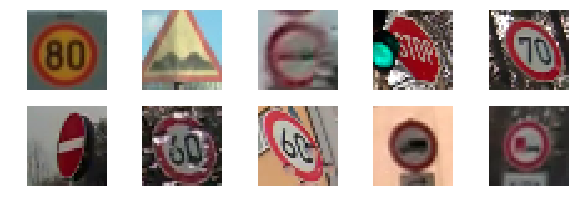

In [10]:
import os

newImages = []
for entry in os.scandir('./newSigns/hard'):
    if entry.is_file():
        print(entry.name)
        img = cv2.imread(entry.path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(32,32))
        newImages.append(img)
        
newImages = np.array(newImages)
        
cols = 5

figsize = (10, 5)
nImages = newImages.shape[0]

gs = gridspec.GridSpec(nImages // cols + 1, cols)

fig1 = plt.figure(num=1, figsize=figsize)
ax = []
for i in range(nImages):
    row = (i // cols)
    col = i % cols
    ax.append(fig1.add_subplot(gs[row, col]))
    #example
    img = newImages[i]
    ax[-1].imshow(img)
    ax[-1].axis('off')

newImagesN = normalizeImageList(newImages)        


### Predict the Sign Type for Each Image

In [11]:
tf.reset_default_graph();
keep_prob = tf.placeholder(tf.float32, name='keep_prob')                                           

batch_x = tf.placeholder(tf.float32, [None,32,32,3], name='batch_x')
batch_y = tf.placeholder(tf.int32, (None),name='batch_y')
ohy = tf.one_hot(batch_y,43,name='one_hot');
fc2 = MixNet(batch_x)

step = tf.Variable(0, trainable=False,name='step')
starter_learning_rate = 1e-3
learning_rate = tf.train.exponential_decay(starter_learning_rate, step, 
                                          70, 0.998, staircase=True)


loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=fc2, labels=ohy))
opt = tf.train.AdamOptimizer(learning_rate)
train_op = opt.minimize(loss_op, global_step = step)
correct_prediction = tf.equal(tf.argmax(fc2, 1), tf.argmax(ohy, 1))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

e_t = tf.where(tf.not_equal(tf.cast(tf.argmax(fc2, 1),tf.int32), batch_y))
softmax = tf.nn.softmax(fc2);        
top_k = tf.nn.top_k(softmax, k=5)

saver = tf.train.Saver();



def test_new_data(xv, yv):
    sess = tf.get_default_session()
 
    loss, acc, err = sess.run([loss_op, accuracy_op, e_t], feed_dict={batch_x : xv , batch_y: yv, keep_prob: 1.0})

    top, result = sess.run([top_k,softmax],   feed_dict={batch_x : xv , keep_prob: 1.0})     
    return top, result , err, loss, acc



#newLabels = [14,28,8,10,4]

newLabels = [5,22,9,14,4,17,3,3,16,10]

print ("testing " , save_file)

with tf.Session() as sess:
    #sess.run(tf.global_variables_initializer())
    saver.restore(sess, save_file)


    top, result, e, val_loss, val_acc = test_new_data(newImagesN[:], newLabels[:]); #Xgn_test,y_test)
    print("Validation loss = {:.3f}".format(val_loss))
    print("Validation accuracy = {:.3f}".format(val_acc))

       


layer2 : (?, 5, 5, 16) ; flattened= (?, 400)
layer3 : (?, 1, 1, 32) ; flattened= (?, 32)
lin1 shape: (?, 432) 432
testing  ./mixNet0_named.ckpt
Validation loss = 2.309
Validation accuracy = 0.600


### Analyze Performance

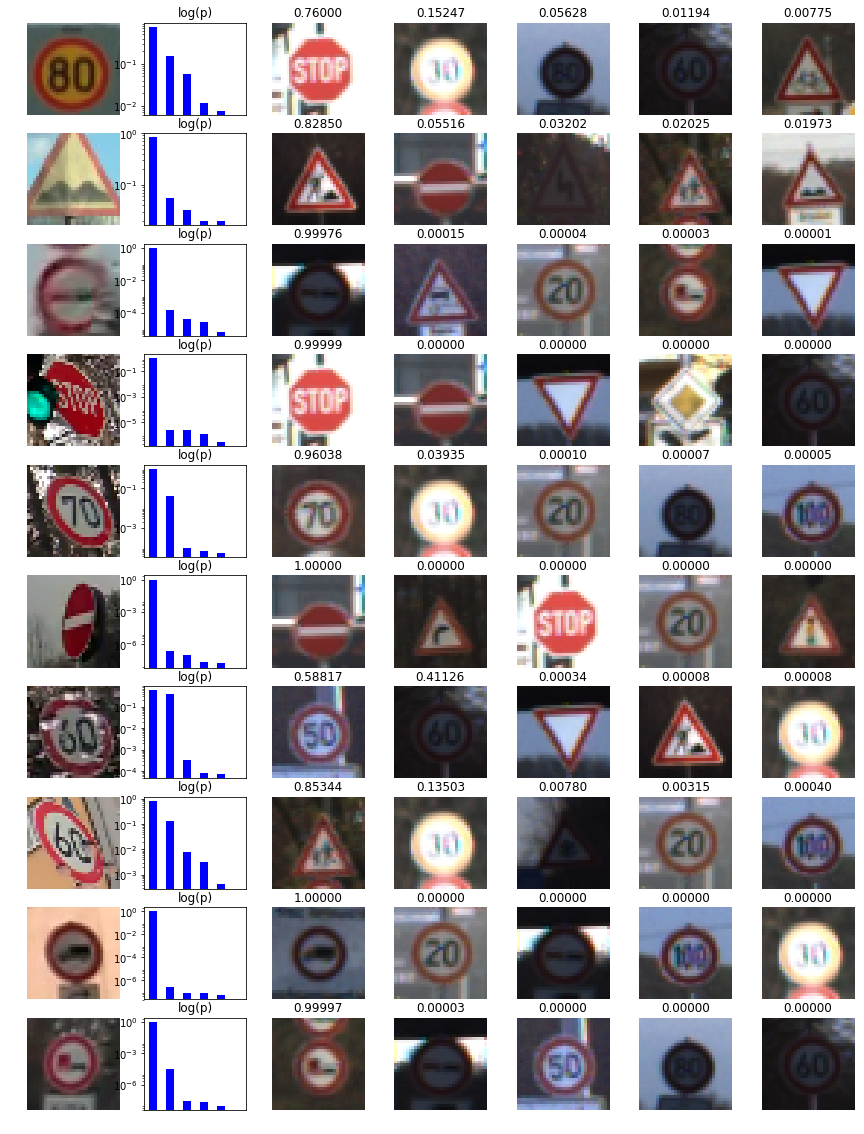

In [13]:
### Calculate the accuracy for these new images. 

nImages = newImages.shape[0]


figsize = (15, 20)

gs = gridspec.GridSpec(nImages , 7)

fig1 = plt.figure(num=1, figsize=figsize)
ax = []
ind = np.arange(5)
for i in range(nImages):
    row = (i)
    ax.append(fig1.add_subplot(gs[row, 0]))
    #example
    img = newImages[i]
    ax[-1].imshow(img)
    ax[-1].axis('off')
    
    ax.append(fig1.add_subplot(gs[row, 1]))
    ax[-1].bar(ind+0.5, top[0][i], 0.5, color='b')
    ax[-1].set_yscale('log')
    ax[-1].set_xlim((0,6))
    ax[-1].set_xticks([])
    ax[-1].set_title('log(p)')
    for t in range (top[1].shape[1]):
        ax.append(fig1.add_subplot(gs[row, 2+t]))
        #example
        img = examples[top[1][i][t]]
        ax[-1].imshow(img)
        ax[-1].set_title('%.5f' % (top[0][i][t]))
        ax[-1].axis('off')

### Project Writeup

Project Writeup you can find in [here](./P2_writeup.md)
